In [1]:
from urllib.parse import urlparse
import json
import os
import re

from lingua import Language, LanguageDetectorBuilder
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm.auto import tqdm
import numpy as np
import scienceplots
import pandas as pd

from utils import get_word_stats, get_domain
tqdm.pandas()

data_dir = "../data/parquet/final/"

plt.rcParams.update({
"font.family": "serif",
"font.serif": ["Times New Roman"],
})

detector = LanguageDetectorBuilder.from_all_languages().build()

In [ ]:
os.makedirs("figures", exists_ok=True)

In [2]:
data_dir = "../data/parquet/split"

data = dict()

for dataset in ["MuMiN-PT", "COVID19.BR", "Fake.br"]:
    #dataset = dataset_path[:-8]    
    data[dataset] = pd.read_parquet(f'{data_dir}/{dataset}.parquet')
    data[dataset].rename(
        columns={"claim_query": "claim", "initial_query": "query", "google_search_results": "results"}, 
        inplace=True
    )
    print(data[dataset].columns)

Index(['text_no_url', 'old_split', 'new_split', 'label', 'query', 'claim',
       'results', 'google_fact_check_results', 'near_duplicates', 'text_urls',
       'metadata'],
      dtype='object')
Index(['text_no_url', 'old_split', 'new_split', 'label', 'query', 'claim',
       'results', 'google_fact_check_results', 'near_duplicates', 'text_urls',
       'metadata'],
      dtype='object')
Index(['text_no_url', 'old_split', 'new_split', 'label', 'query', 'claim',
       'results', 'google_fact_check_results', 'near_duplicates', 'text_urls',
       'metadata'],
      dtype='object')


In [ ]:
stages = ["(1)", "(2)", "(3)"]
Resultado = ["Sucess", "Fail"]

funnels = list()
for dataset in data:
    funnel = [
        {"Step": stages[0], "n": data[dataset].shape[0], "Corpus": dataset, "Result": "Sucess"},
        {"Step": stages[1], "n": data[dataset][data[dataset]["claim"].notna()].shape[0], "Corpus": dataset, "Result": "Sucess"},
        {"Step": stages[2], "n": data[dataset][data[dataset]["claim"].notna() & data[dataset]["results"].notna()].shape[0], "Corpus": dataset, "Result": "Sucess"},
        {"Step": stages[2], "n": data[dataset][data[dataset]["claim"].notna() & data[dataset]["results"].isna()].shape[0], "Corpus": dataset, "Result": "Fail"},
    ]

    funnels.extend(funnel)

fig = px.funnel(
    funnels, y="Step", x="n", facet_col="Corpus", width=1000, template="seaborn", color_discrete_sequence=px.colors.qualitative.G10,
    color="Result"
)

for a in fig.layout.annotations:
    a.text = a.text.split("=")[1]

fig.update_layout(font=dict(size=25, family="serif"))
fig.write_image("../figures/funnel.pdf")

In [ ]:
data_claim, data_words = get_word_stats(data, "claim")

stats = pd.DataFrame()

for dataset in data_claim:
   row = data_claim[dataset][["n_words", "avg_word_size", "n_sents", "n_words_per_sent"]].mean()
   row["dataset"] = dataset
   
   if stats.empty:
    stats = row
   else:
    stats = pd.concat([row, stats], axis=True)

stats = stats.T.set_index("dataset")

In [8]:
stats

,n_words,avg_word_size,n_sents,n_words_per_sent
dataset,,,,
Fake.br,12.243465,4.803075,1.004357,12.220634
COVID19.BR,12.091542,4.904649,1.009636,12.038544
MuMiN-PT,11.153226,4.870524,1.006048,11.101815


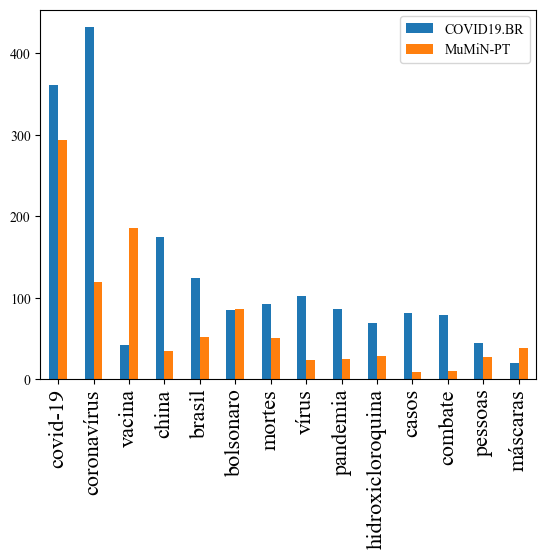

In [9]:
data_words = {d: dict(data_words[d]) for d in data_words}
data_words = pd.DataFrame(data_words).fillna(0).astype(int)
if "vacinas" in data_words.index:
    data_words.loc["vacina"] += data_words.loc["vacinas"]
    data_words.loc["vacina"] += data_words.loc["vacinação"]
    data_words.drop(index=["vacinas", "vacinação"], inplace=True)

if "url" in data_words.index:
    data_words.drop(index=["url"], inplace=True)

data_words["Total"] = data_words.sum(axis=True)
data_words.sort_values("Total", ascending=False, inplace=True)

#data_words.drop(index="url", inplace=True)
data_words.rename(index={"covid00": "covid-19", "expresidente": "ex-presidente"}, inplace=True)
covid_words = data_words[["COVID19.BR", "MuMiN-PT"]]

top_covid = set(covid_words["MuMiN-PT"].sort_values(ascending=False).head(10).index)
top_covid.update(set(covid_words["COVID19.BR"].sort_values(ascending=False).head(10).index))

covid_words = covid_words.loc[list(top_covid)]
covid_words = covid_words.loc[covid_words.sum(axis=True).sort_values(ascending=False).index]

plt.rc('xtick', labelsize=16) 

covid_words.plot(kind="bar")
plt.savefig("../figures/covid_claim.svg", format="svg", bbox_inches='tight')

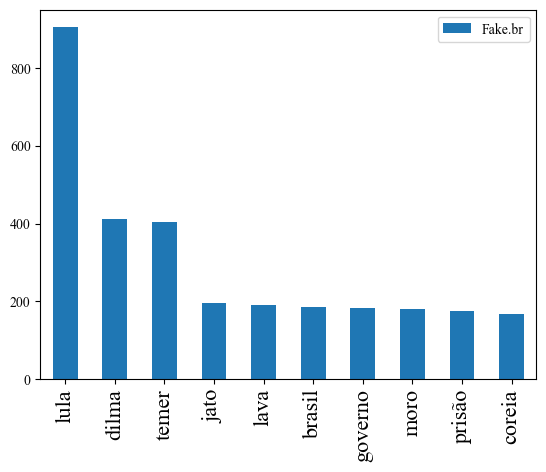

In [10]:
fake_data = data_words[["Fake.br"]]
fake_data = fake_data[fake_data != 0].dropna().astype(int)
fake_data.sort_values("Fake.br", inplace=True, ascending=False)
fake_data = fake_data.head(10)
plt.rc('xtick', labelsize=16) 
fake_data.plot(kind="bar")
plt.savefig("../figures/fakebr_claim.svg", format="svg", bbox_inches='tight')

-> Claim top words very similar to originals

In [11]:
count = []
for dataset in data:
    data_var = data[dataset]["results"].apply(lambda rs: sum([1 for r in rs if r["pagemap"].get("claim_review")])  if isinstance(rs, np.ndarray) else 0)
    d_count = data_var[data_var > 0].describe().to_frame(name=dataset).T

    for column in ["count", "max"]:
        d_count[column] = d_count[column].astype(int)

    d_count["percent"] = d_count["count"]/data[dataset].shape[0]*100

    for column in ["percent", "mean", "std"]:
        d_count[column] = d_count[column].round(1)

    d_count = d_count[["percent", "count", "mean", "std", "max"]]
    
    count.append(d_count)

count = pd.concat(count)
count.sort_values("percent", inplace=True, ascending=False)
count

,percent,count,mean,std,max
MuMiN-PT,21.3,299,1.2,0.5,3
COVID19.BR,1.0,19,1.3,0.5,2
Fake.br,0.6,44,1.1,0.3,2


- Makes sense considering collection approach (top-down vs bottom-up)

In [ ]:
match_idx = list()

for dataset in data:
    df = data[dataset]
    df = df[df["claim"].isna() & df["results"].notna()]
    df = df["results"].apply(lambda results: np.argmax([r["match"] if isinstance(r["match"], float) else 0 for r in results]) + 1)
    df = df.value_counts(normalize=True)
    df.name = dataset
    df.index.name = "Correspondence"
    match_idx.append(df)

match_idx = pd.concat(match_idx, axis=True)
match_idx = match_idx.sort_index()
match_idx.plot(kind="bar")
plt.savefig("../figures/match_idx.svg", format="svg", bbox_inches='tight')

In [13]:
match_idx

,MuMiN-PT,COVID19.BR,Fake.br
Correspondência,,,
1,0.655340,0.596639,0.552039
2,0.133495,0.184874,0.198312
3,0.106796,0.092437,0.139944
4,0.038835,0.042017,0.059775
5,0.065534,0.084034,0.049930


In [14]:
pdfs_articles = set()

for dataset in data:
    pdfs_dataset = data[dataset]["results"].apply(lambda rs: {r["link"] for r in rs if isinstance(r["match"], float) and r["match"] >= 0.8 and r["link"].endswith(".pdf")} if isinstance(rs, np.ndarray) else [])
    pdfs_dataset = {item for _ in pdfs_dataset for item in _}
    pdfs_articles = pdfs_articles.union(pdfs_dataset)

to_remove = {
    'http://cesrei.edu.br/site/wp-content/uploads/2018/04/CESREI-ECOM-2017-M%C3%8DDIA-E-SOCIEDADE_-AS-REPRESENTA%C3%87%C3%95ES-DOS-USU%C3%81RIOS-DE-ENTORPECENTES-DA-CRACOL%C3%82NDIA-NO-G1.pdf',
    'http://observatorio.repri.org/wp-content/uploads/2022/09/Dossi%C3%AA-Elei%C3%A7%C3%B5es-2022-Vers%C3%A3o-Final-Portugu%C3%AAs-3-Jair-Bolsonaro.pdf',
    'http://repositorio.asces.edu.br/bitstream/123456789/2796/1/Trabalho%20de%20Conclus%C3%A3o%20de%20Curso%20-%20Thiago%20Marinho%20-%20Vers%C3%A3o%20Reposit%C3%B3rio.pdf',
    'http://repositorio.asces.edu.br/bitstream/123456789/3457/1/TCC%20%28TRABALHO%20DE%20CONCLUS%C3%83O%20DE%20CURSO%29%20DEP%C3%93SITO%20FINAL%20-%20HELLEN%20NATH%C3%81LIA%2C%20JOS%C3%89%20JOBSON%2C%20RAUDIN%C3%8AZ%20JOS%C3%89.pdf',
    'http://repositorio.undb.edu.br/bitstream/areas/397/1/EVILYN%20KANANDA%20TAVEIRA%20RODRIGUES.pdf',
    'http://site.conpedi.org.br/publicacoes/4k6wgq8v/cyu6j6f0/5aPD2385d72a1m51.pdf',
    'http://www.professoraanafrazao.com.br/files/publicacoes/2017-11-29-Big_data_e_impactos_sobre_a_analise_concorrencial.pdf',
    'http://www.unieuro.edu.br/sitenovo/revistas/revista_hegemonia_22/Jos%C3%A9%20Gilbert%20Arruda%20Martins%20(6).pdf',
    'https://arquivos.qconcursos.com/prova/arquivo_prova/63199/igdrh-2017-cremerj-agente-administrativo-prova.pdf',
    'https://arquivos.ufrrj.br/arquivos/202110621882f52942026b463e0bc22c5/MONOGRAFIA_ADRIELLE_DO_VALE_DELGADO.pdf',
    'https://bdex.eb.mil.br/jspui/bitstream/123456789/10723/1/Interven%C3%A7%C3%A3o%20a%20reestrutura%C3%A7%C3%A3o%20da%20seguran%C3%A7a%20p%C3%BAblica%20no%20Estado%20do%20Rio%20de%20Janeiro.pdf',
    'https://bdex.eb.mil.br/jspui/bitstream/123456789/12985/1/9568%20Lucas%20Henrique%20Lopes%20Moura.pdf',
    'https://bdex.eb.mil.br/jspui/bitstream/123456789/3969/1/TCC_SILVA.pdf',
    'https://bdex.eb.mil.br/jspui/bitstream/123456789/5354/1/AC%20CAP%20LIRA.pdf',
    'https://bdex.eb.mil.br/jspui/bitstream/123456789/5743/1/6005.pdf',
    'https://bdex.eb.mil.br/jspui/bitstream/123456789/8614/1/Art%20Cient%C3%ADfico%20Pimenta.pdf',
    'https://bradonegro.com/content/arquivo/12122018_105854.pdf',
    'https://bvsms.saude.gov.br/bvs/publicacoes/suicidio_saber_agir_prevenir.pdf',
    'https://cebri.org/revista/media/revistas/arquivos/CEBRI-Revista_2a_ed_Abr-Jun202.pdf',
    'https://conteudo.imguol.com.br/c/noticias/documentos/Palocci.pdf',
    'https://dialnet.unirioja.es/descarga/articulo/7884916.pdf',
    'https://dialnet.unirioja.es/descarga/articulo/9230543.pdf',
    'https://dspace.doctum.edu.br/bitstream/123456789/3552/1/Rodrigo%20Jaernevay.tcc.pdf',
    'https://editorarealize.com.br/editora/anais/conedu/2018/TRABALHO_EV117_MD4_SA16_ID9715_10092018103105.pdf',
    'https://efape.educacao.sp.gov.br/curriculopaulista/wp-content/uploads/2020/12/AF-9%C2%BA-ano-Aluna.pdf',
    'https://eje.tre-ba.jus.br/pluginfile.php/13245/mod_label/intro/artigo%206%20-%20Frederico%20Franco%20Alvim%20e%20Josbertini%20Virg%C3%ADlio%20Clementino%20-%20109-128.pdf',
    'https://emerj.tjrj.jus.br/files/pages/paginas/trabalhos_conclusao/2semestre2019/pdf/AmandaFerreiradaSilva.pdf',
    'https://emerj.tjrj.jus.br/files/pages/paginas/trabalhos_conclusao/2semestre2020/pdf/JADE-FERRONATTO-GIRON.pdf',
    'https://flucianofeijao.com.br/flf/wp-content/uploads/2019/11/DO_SAMBA_AO_FUNK_QUANDO_RITMOS_VIRAM_CASOS_DE_POLICIA.pdf',
    'https://international-review.icrc.org/sites/default/files/reviews-pdf/2023-06/is-rio-de-janeiro-preparing-for-war-923.pdf',
    'https://eventos.ufu.br/sites/eventos.ufu.br/files/documentos/gustavodesouzarubbilarissacristinabatistaualissonpereirafreitas_0.pdf',
    'https://library.fes.de/pdf-files/bueros/brasilien/13249.pdf',
    'https://ncdalliance.org/sites/default/files/resource_files/Civil%20Society%20Status%20Report%20ACT.pdf',
    'https://pantheon.ufrj.br/bitstream/11422/12593/1/JSilva.pdf',
    'https://portalpatrimonio.bradesco.com.br/BradescoBradespar/static_files/assets/pdf/fatos-relevantes/Comunicado_ao_Mercado_01-06-2016.pdf',
    'https://repositorio.bahiana.edu.br:8443/jspui/bitstream/bahiana/7120/1/Iris%20Beatriz%20Cana%20Brasil%20Santos%20-%20Ra%C3%A7a%20e%20medicina%20um%20olhar%20para%20a%20viv%C3%AAncia%20de%20estudantes%20negros%20de%20medicina%20em%20uma%20institui%C3%A7%C3%A3o%20privada%20de%20ensino%20-%202022.pdf',
    'https://repositorio.enap.gov.br/bitstream/1/6451/4/Apostila%20do%20M%C3%B3dulo%20III.pdf',
    'https://repositorio.pgsscogna.com.br/bitstream/123456789/48800/1/VANESSA%20YAMASHIRO.pdf',
    'https://repositorio.pucgoias.edu.br/jspui/bitstream/123456789/2415/1/N%C3%8DNYVE%20PEDROSO%20RODRIGUES%20-%20TCC.pdf',
    'https://repositorio.ufba.br/bitstream/ri/26748/3/DavidRomaoTeixeira.Tese.Educa%C3%A7%C3%A3o.UFBA.pdf',
    'https://repositorio.ufba.br/bitstream/ri/32529/1/2.Disserta%C3%A7%C3%A3o%20Final_Mylena%20Souza%20Alecrim_PPGCS-UFBA.pdf',
    'https://repositorio.ufba.br/bitstream/ri/38534/1/Tese%20de%20Doutorado%20-%20Juliana%20Campos%20Maltez%20-%28PPGCS%20-UFBA%29.pdf',
    'https://repositorio.ufpa.br/jspui/bitstream/2011/12716/1/Dissertacao_MidiaDiasporaVenezuelana.pdf',
    'https://repositorio.ufpb.br/jspui/bitstream/123456789/22534/1/PolyannaFigueir%C3%AAdoDeAndrade_Dissert.pdf',
    'https://repositorio.ufpb.br/jspui/bitstream/123456789/26438/1/GCP211222.pdf',
    'https://repositorio.ufpe.br/bitstream/123456789/30963/1/Renan%20Apol%C3%B4nio%20de%20S%C3%A1%20Silva.pdf',
    'https://www.univali.br/Lists/TrabalhosMestrado/Attachments/3054/DISSERTAC%CC%A7A%CC%83O%20DANIELA%20-%20FINAL%20-%20SETEMBRO%202022%20(alterado).pdf',
    'https://www.repositorio.ufal.br/bitstream/123456789/13522/1/M%C3%A3es%20universit%C3%A1rias%20desafios%20e%20possibilidades%20em%20conciliar%20maternidade%20e%20educa%C3%A7%C3%A3o.pdf',
    'https://www.sed.sc.gov.br/wp-content/uploads/2024/10/Passo_a_passo_vcnijma_03_NOV_2017.pdf',
    'https://www.thieme-connect.com/products/ejournals/pdf/10.1055/s-0042-1755226.pdf',
    'https://www.mpf.mp.br/df/sala-de-imprensa/docs/copy2_of_ACP_DF.pdf',
    'https://www.mpgo.mp.br/revista/pdfs_14/8artigo22FINAL_Layout_1.pdf',
    'https://www.mpsp.mp.br/portal/page/portal/documentacao_e_divulgacao/doc_biblioteca/bibli_servicos_produtos/BibliotecaDigital/BibDigitalLivros/TodosOsLivros/Critica-a-prisao-preventiva-no-ambito-da-colaboracao-premiada.pdf',
    'https://www.redalyc.org/journal/698/69876423022/69876423022_26.pdf',
    'https://www.gov.br/anvisa/pt-br/assuntos/servicosdesaude/prevencao-e-controle-de-infeccao-e-resistencia-microbiana/ManualdeRefernciaTcnica.pdf',
    'https://www.gov.br/defesa/pt-br/arquivos/ajuste-01/ensino_e_pesquisa/defesa_academia/cadn/XV_cadn/possibilidadesa_ea_desafiosa_daa_intervencaoa_militara_noa_rioa_dea_janeiro.pdf',
    'https://www.ibraop.org.br/wp-content/uploads/2020/10/ClippingIbraop_31edi.pdf',
    'https://www.monografias.ufop.br/bitstream/35400000/6230/3/MONOGRAFIA_Percep%C3%A7%C3%A3oTrag%C3%A9diaAn%C3%A1lise.pdf',
    'https://tede2.pucgoias.edu.br/bitstream/tede/4622/2/Soraya%20Pereira.pdf',
    'https://www.bdtd.uerj.br:8443/bitstream/1/18576/2/Disserta%C3%A7%C3%A3o%20-%20Luis%20Fernando%20Freire%20Ramadon%20Porto%20Alegre%20-%202020%20-%20Completa.pdf',
    'https://www.camara.leg.br/stf/Inq4483/INQ_4483_Volume_12_Fl._2.941_DVD/6_2%20AC%204316%20-%20Interceptacao%20Tel%20(Aecio%20e%20outros)/AC4316_VOLUME_01.pdf',
    'https://tede.utp.br/jspui/bitstream/tede/1608/2/FATORES%20DE%20RISCO.pdf',
    'https://spo.ifsp.edu.br/images/phocadownload/DOCUMENTOS_MENU_LATERAL_FIXO/POS_GRADUA%C3%87%C3%83O/MESTRADO/Ensino_de_Ci%C3%AAncias_e_Matem%C3%A1tica/Dissertacoes/2023/LuziaAguiar_Dissertacao_e_Produto_2023_VersaoFinal_1.pdf',
    'https://repositorio.unisc.br/jspui/bitstream/11624/1953/1/Betina%20de%20Souza.pdf',
    'https://repositorium.sdum.uminho.pt/bitstream/1822/65595/1/DissertacaoMonique_LO%2B3%2Bdez%2B2019%2B%281%29.pdf',
    'https://repositorio.ufpe.br/bitstream/123456789/56921/3/TCC%20VANESSA%20BEATRIZ%20XAVIER%20DE%20ALBUQUERQUE.pdf',
    'https://repositorio.uft.edu.br/bitstream/11612/4779/1/POLIANA%20AIRES%20DA%20LUZ%20-%20TCC%20-%20LETRAS.pdf',
    'http://www.edufrn.ufrn.br/bitstream/123456789/2592/4/NOVO%20JORNAL%2005.012017.pdf',
    'https://dialnet.unirioja.es/descarga/articulo/9301572.pdf',
    'https://dialnet.unirioja.es/descarga/articulo/9396448.pdf',
    'https://milobs.pt/wp-content/uploads/2021/09/A-gest%C3%A3o-do-discurso-de-%C3%B3dio-nas-plataformas-de-redes-sociais-digitais-um-comparativo-entre-Facebook-Twitter-e-Youtube.pdf'
}


pdfs_articles -= to_remove

articles = {
    #"https://repositorio.unichristus.edu.br/jspui/bitstream/123456789/1745/1/TCC__Mirella_final.pdf",
    #"https://repositorio.ufpe.br/bitstream/123456789/39074/4/DISSERTA%C3%87%C3%83O%20Suelen%20Mazza%20Batista.pdf",
    "https://sur.conectas.org/wp-content/uploads/2018/07/sur-27-portugues-marcio-moretto-ribeiro-pablo-ortellado.pdf",
    "http://www.uel.br/cce/dc/wp-content/uploads/TCC_GUILHERME_SAKURAI.pdf",
    "https://repositorio.ufu.br/bitstream/123456789/37660/1/Classifica%C3%A7%C3%A3odeNot%C3%ADciasDigitais.pdf",
    "https://tede.utp.br/jspui/bitstream/tede/1856/2/TEM%20DUVIDA.pdf",
    "https://run.unl.pt/bitstream/10362/128081/1/Vers%C3%A3o%20corrigida%20e%20melhorada-%20Disserta%C3%A7%C3%A3o%20de%20Mestrado%20em%20Ci%C3%AAncias%20da%20Linguagem-%20Vanessa%20Daiane%20Contente%20Quintanilha-converted.pdf",
    "https://bdm.ufpa.br/bitstream/prefix/4440/1/Artigo_FakeNewsSobre.pdf",
    "https://dialnet.unirioja.es/descarga/articulo/8093852.pdf",
    "http://compolitica.org/novo/anais/2019_gt4_Ituassu.pdf",
    "https://anpocs.org.br/wp-content/uploads/2023/07/42CPM.pdf",
    "https://www.dbd.puc-rio.br/pergamum/tesesabertas/1712862_2019_completo.pdf",
    "https://seloppgcomufmg.com.br/wp-content/uploads/2021/10/A-pauta-da-desinformacao-Selo-PPGCOM-UFMG-4.pdf",
    'https://jornal.usp.br/wp-content/uploads/2023/10/2-Luiza-Prevedel.pdf',
    'https://repositorio.ufc.br/bitstream/riufc/59268/3/2021_dis_icsa.pdf',
    'https://riu.ufam.edu.br/bitstream/prefix/6934/2/TCC_FelipeGusm%C3%A3o.pdf'
}

In [15]:
from pprint import pprint


print(len(pdfs_articles))

for dataset in data:
    pdf = data[dataset]["results"].apply(lambda rs: [r for r in rs if isinstance(r["match"], float) and r["match"] >= 0.8 and any(r["link"] == a for a in pdfs_articles)] if isinstance(rs, np.ndarray) else [])
    data[dataset]["results_pdf"] = pdf
    selected = data[dataset][pdf.apply(len) > 0]
    selected = selected[selected["label"] == "fake"]
    pprint(selected.shape)

23
(20, 12)
(2, 12)
(15, 12)


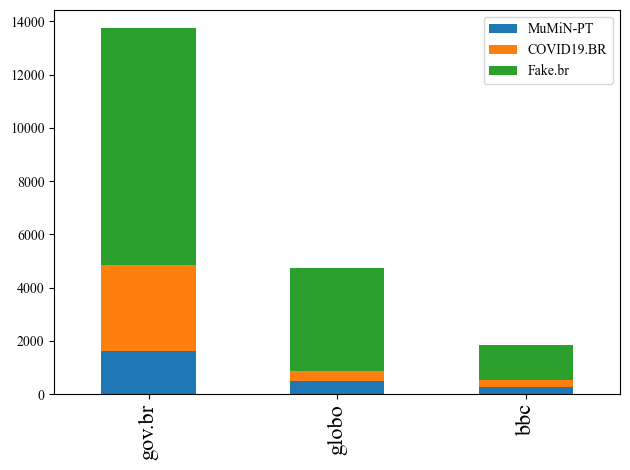

In [16]:
n = 3

for dataset in data:
    data[dataset]["results_url"] = data[dataset]["results"].apply(lambda rs: [r["link"] for r in rs] if isinstance(rs, np.ndarray) else [])


data_url = get_domain(data, col="results_url", drop_mumin=False)
#data_url *= 100/data_url.sum()

candidates = set() 
for dataset in data_url:
    candidates = candidates.union(data_url[dataset].sort_values(ascending=False).head(n).index) 


data_url = data_url.loc[list(candidates)].sort_values("Total", ascending=False).head(3).drop(columns="Total")


data_url.plot(kind="bar", stacked=True)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=14)  
plt.tight_layout()
plt.savefig("../figures/domain.svg")

In [19]:
for dataset in data:
    data[dataset]["agents_url"] = data[dataset]["results"].apply(lambda rs: [r["link"] for r in rs if r["pagemap"].get("claim_review")] if isinstance(rs, np.ndarray) else [])

data_url = get_domain({d: data[d] for d in data}, col="agents_url", drop_mumin=False)
data_url = data_url.head(10).sort_values("Total", ascending=False).drop(columns=["Total"])
data_url

,MuMiN-PT,COVID19.BR,Fake.br
afp,154,8,10
uol,95,5,11
observador,80,4,4
estadao,11,4,17
e-farsas,8,0,1
sbt,0,3,5
globo,7,0,0
projetocomprova,7,0,0
sapo,0,0,1


In [20]:
for dataset in data:
    percent = data[dataset]["agents_url"].apply(lambda l: len(l) > 0).value_counts(normalize=True)
    percent *= 100
    print(dataset, percent.round(1))

MuMiN-PT agents_url
False    78.7
True     21.3
Name: proportion, dtype: float64
COVID19.BR agents_url
False    99.0
True      1.0
Name: proportion, dtype: float64
Fake.br agents_url
False    99.4
True      0.6
Name: proportion, dtype: float64


In [21]:
data_dates = list()

for dataset in data:
    dates = data[dataset]["results"].apply(lambda rs: [r["pagemap"] for r in rs ] if isinstance(rs, np.ndarray) else [])
    dates = dates.apply(lambda rs: [r["date_review"] for r in rs if "date_review" in r.keys() and r["date_review"] != None])
    dates = dates[dates.apply(len) > 0].apply(min)
    #dates = dates.apply(lambda d: "-".join(d.split("T")[0].split("-")[:-1]))
    dates = dates.apply(lambda d: d.split("T")[0])
    dates = pd.to_datetime(dates).value_counts().reset_index(name=dataset)
    data_dates.append(dates)

data_dates = pd.concat(data_dates)
data_dates = data_dates.set_index("results")
data_dates.sort_values("results", inplace=True)
data_dates = data_dates.fillna(0).astype(int)
data_dates.index.name = ""

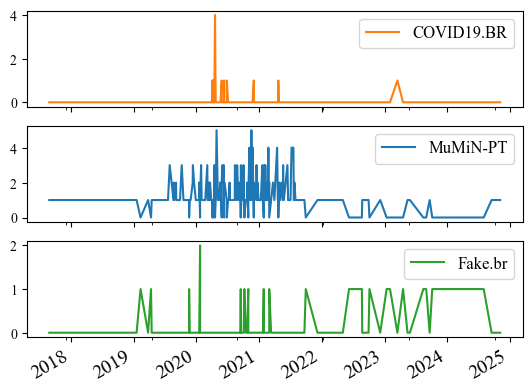

In [22]:
data_dates.plot(subplots=[["COVID19.BR"],["MuMiN-PT"],["Fake.br"]])
plt.savefig("../figures/dates.svg")

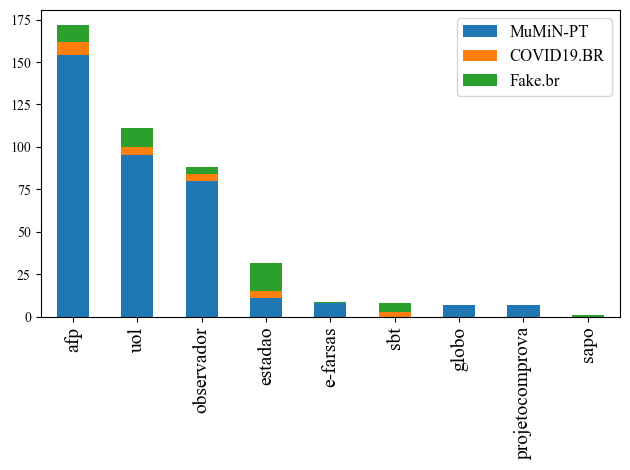

In [23]:
data_url.plot(kind="bar", stacked=True)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=14)  
plt.tight_layout()